In [7]:
using DelimitedFiles, HDF5, FileIO
using Plots, Rsvg, LaTeXStrings
using Chemfiles, JUMD, DataFrames
using LinearAlgebra, Statistics, NamedArrays
home = "/home/pbarletta/labo/20/dynein/run"
rtdos = "/home/pbarletta/labo/20/dynein/rtdos_log"

"/home/pbarletta/labo/20/dynein/rtdos_log"

### Lee modos, volumen original y  volúmenes NDD. Obtiene VGV

In [2]:
pdb = "3fm7"
# Leo modos
modes_3fm7, evals_3fm7 = JUMD.readPtrajModes(joinpath(home, pdb,  "pca", string("modes_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_3fm7))
aa = convert(Int64, aa3 / 3)

# Leo volumen de la traj
trj_vol_acb = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "cavidad", "vol_acb_trj_het"))[:, 3]);
trj_vol_adb = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "cavidad", "vol_adb_trj_het"))[:, 3]);
trj_vol_ecf = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "cavidad", "vol_ecf_trj_het"))[:, 3]);
trj_vol_edf = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "cavidad", "vol_edf_trj_het"))[:, 3]);

# Leo volúmenes originales
vol_avg_acb = convert(Float64, readdlm(joinpath(home, pdb,  "cavidad", "vol_acb_het"))[3])
vol_avg_adb = convert(Float64, readdlm(joinpath(home, pdb,  "cavidad", "vol_adb_het"))[3])
vol_avg_ecf = convert(Float64, readdlm(joinpath(home, pdb,  "cavidad", "vol_ecf_het"))[3])
vol_avg_edf = convert(Float64, readdlm(joinpath(home, pdb,  "cavidad", "vol_edf_het"))[3])

209.008

## Volumen de la trayectoria

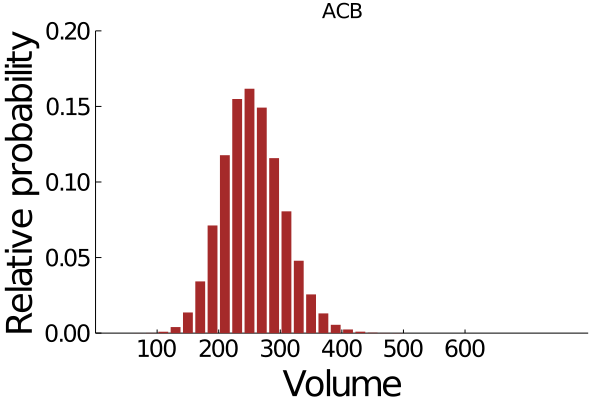

In [28]:
st = 20
bin_vol = collect(0:st:800)
wgh_vol = fill(1.0, length(trj_vol_acb))

# Histograma ponderado
Wbins_vol_acb, Whis_vol_acb = JUMD.weightedHist(trj_vol_acb, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_acb, Whis_vol_acb,
    xlims = (0, 800), ylims = (0, .2),
    xticks = 100:100:600,
    linecolor = false, fillcolor = Colors.colorant"Brown",
    grid = false, legend = false,
    guidefont = font(24, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"),
    title = "ACB", yaxis = "Relative probability", xaxis = "Volume")

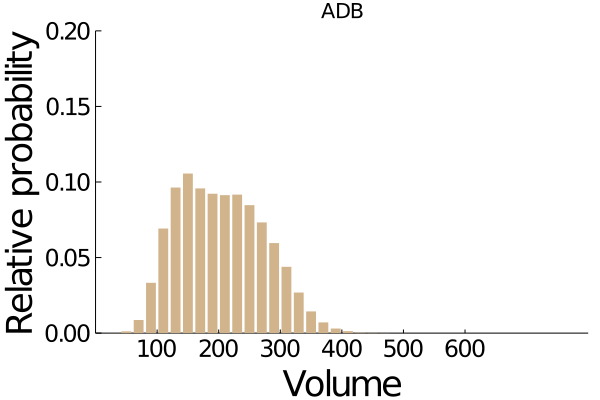

In [29]:
st = 20
bin_vol = collect(0:st:800)
wgh_vol = fill(1.0, length(trj_vol_adb))

# Histograma ponderado
Wbins_vol_adb, Whis_vol_adb = JUMD.weightedHist(trj_vol_adb, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_adb, Whis_vol_adb,
    xlims = (0, 800), ylims = (0, .2),
    xticks = 100:100:600,
    linecolor = false, fillcolor = Colors.colorant"Tan",
    grid = false, legend = false,
    guidefont = font(24, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"),
    title = "ADB", yaxis = "Relative probability", xaxis = "Volume")

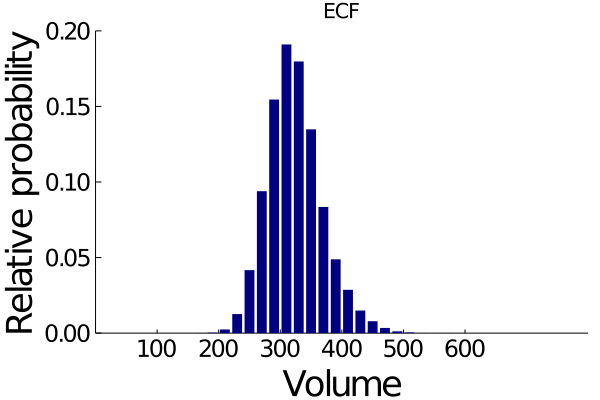

In [30]:
st = 20
bin_vol = collect(0:st:800)
wgh_vol = fill(1.0, length(trj_vol_ecf))

# Histograma ponderado
Wbins_vol_ecf, Whis_vol_ecf = JUMD.weightedHist(trj_vol_ecf, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_ecf, Whis_vol_ecf,
    xlims = (0, 800), ylims = (0, .2),
    xticks = 100:100:600,
    linecolor = false, fillcolor = Colors.colorant"Navy",
    grid = false, legend = false,
    guidefont = font(24, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"),
    title = "ECF", yaxis = "Relative probability", xaxis = "Volume")

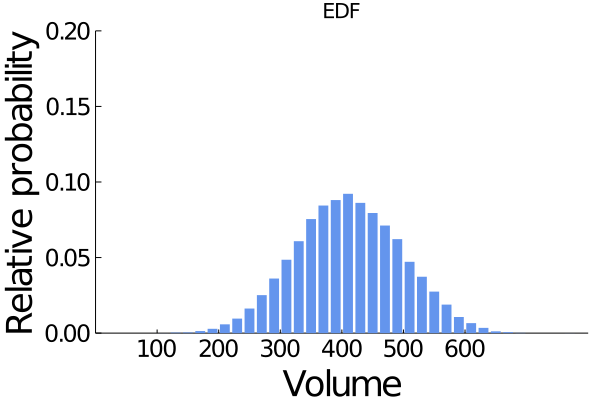

In [31]:
st = 20
bin_vol = collect(0:st:800)
wgh_vol = fill(1.0, length(trj_vol_edf))

# Histograma ponderado
Wbins_vol_edf, Whis_vol_edf = JUMD.weightedHist(trj_vol_edf, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_edf, Whis_vol_edf,
    xlims = (0, 800), ylims = (0, .2),
    xticks = 100:100:600,
    linecolor = false, fillcolor = Colors.colorant"CornflowerBlue",
    grid = false, legend = false,
    guidefont = font(24, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"),
    title = "EDF", yaxis = "Relative probability", xaxis = "Volume")

In [7]:
DataFrame(
    Volume = [ mean(trj_vol_acb) ; mean(trj_vol_adb) ; mean(trj_vol_ecf) ; mean(trj_vol_edf) ],
    STD = [ std(trj_vol_acb) ; std(trj_vol_adb) ; std(trj_vol_ecf) ; std(trj_vol_edf) ])

,Volume,STD
,Float64,Float64
1,254.972,48.8779
2,203.998,69.1177
3,323.883,44.2014
4,410.818,85.2728


# PCA projección
#### Obtengo vectores diferencia de la trayectoria. Esto lo hago una sola vez

function diff_trj_avg(in_avg_filename::AbstractString, in_trj_filename::AbstractString,
        mask::Array{Int64, 1})
    in_avg_trj = Trajectory(in_avg_filename)
    in_avg_frm = read(in_avg_trj)
    in_avg_top = Topology(in_avg_frm)
    orig_aa = convert(Int64, count_residues(in_avg_top))

    # Get indices de CA
    orig_cas_idx = Array{Int64, 1}(undef, orig_aa)
    k = 0
    for i = 0:convert(Int64, size(in_avg_top)-1)
        if Chemfiles.name(Atom(in_avg_frm, i)) == "CA"
            k+=1
            orig_cas_idx[k] = i + 1
        end
    end
    cas_idx = orig_cas_idx[mask]
    aa = length(cas_idx)
    aa_3 = aa * 3
    # Estas son las coordenadas q voy a usar p/ restar
    avg_xyz = positions(in_avg_frm)[:, cas_idx];

    # Preparo
    in_trj = Trajectory(in_trj_filename)
    nframes = convert(Int64, length(in_trj))
    close(in_trj)
    diff_pdb = Array{Float64, 2}(undef, aa_3, nframes)
    vec_nframes = convert(Array{Int64}, collect(0:nframes/10:nframes));

    # Ahora obtengo las proyecciones
    for j = 1:length(vec_nframes)-1
        in_trj = Trajectory(in_trj_filename)
        for i = vec_nframes[j]:vec_nframes[j+1]-1
            diff_pdb[:, i+1] =
                reshape(positions(read_step(in_trj, i))[:, cas_idx] .- avg_xyz, aa_3)
        end
        close(in_trj)
        println(j)
        GC.gc()
    end

    return diff_pdb
end

dif = diff_trj_avg(joinpath(home, pdb, "pca", string("avg_", pdb, ".pdb")),
    joinpath(home, pdb, "pca", string("full_avgfit_", pdb, ".nc")),
    collect(1:429))

fid = h5open(joinpath(rtdos, string("diff_", pdb, ".h5")), "w")
write(fid, "dif",dif)
close(fid)

#### Obtengo las proyecciónes de vectores diferencia sobre los 1eros PCA

In [3]:
dif = h5read(joinpath(rtdos, string("diff_", pdb, ".h5")), "dif")
norm_dif = mapslices(x -> x ./ norm(x), dif, dims = 1)
nframes = size(dif)[2]

prj_1_3fm7 = Array{Float64, 1}(undef, nframes)
prj_2_3fm7 = Array{Float64, 1}(undef, nframes)
prj_3_3fm7 = Array{Float64, 1}(undef, nframes)

for i = 1:nframes
    prj_1_3fm7[i] = dot(norm_dif[:, i], modes_3fm7[:, 1])
    prj_2_3fm7[i] = dot(norm_dif[:, i], modes_3fm7[:, 2])
    prj_3_3fm7[i] = dot(norm_dif[:, i], modes_3fm7[:, 3])
end

# Smooth
smooth_prj_1_3fm7 = [ mean(prj_1_3fm7[i:i+9]) for i = 1:10:length(prj_1_3fm7)-9 ]
smooth_prj_2_3fm7 = [ mean(prj_2_3fm7[i:i+9]) for i = 1:10:length(prj_2_3fm7)-9 ]
smooth_prj_3_3fm7 = [ mean(prj_3_3fm7[i:i+9]) for i = 1:10:length(prj_3_3fm7)-9 ];

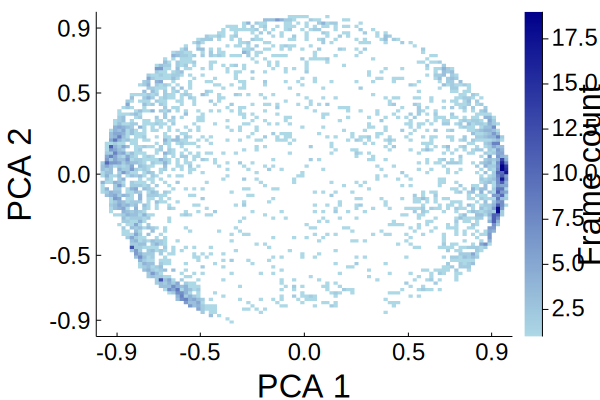

In [4]:
plt_2his = histogram2d(smooth_prj_1_3fm7, smooth_prj_2_3fm7, 
    xlims = (-1, 1), ylims = (-1, 1),
    xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
    yaxis = "PCA 2", xaxis = "PCA 1",
    colorbar_title = "Frame count",
    guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"), #clims = (0, 15),
    nbins = 120, seriescolor = :blues, grid = false)

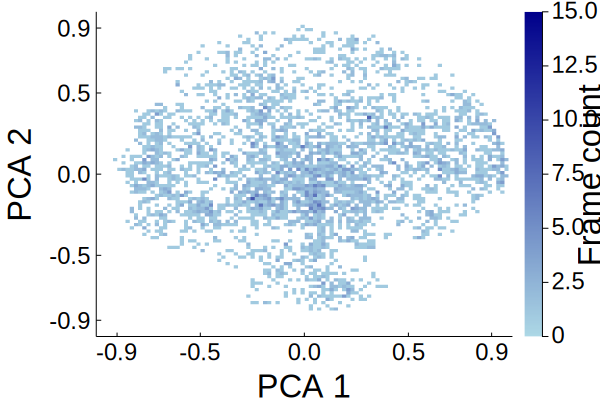

In [15]:
plt_2his = histogram2d(smooth_prj_2_3fm7, smooth_prj_3_3fm7, 
    xlims = (-1, 1), ylims = (-1, 1),
    xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
    yaxis = "PCA 2", xaxis = "PCA 1",
    colorbar_title = "Frame count",
    guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"), clims = (0, 15),
    nbins = 120, seriescolor = :blues, grid = false)

### Defino los frames a partir de los cuales saco 4 réplicas

In [8]:
pca1_min = findmin(prj_1_3fm7)
pca1_max = findmax(prj_1_3fm7)
pca2_min = findmin(prj_2_3fm7)
pca2_max = findmax(prj_2_3fm7)

NamedArray( [ pca1_min pca1_max ; pca2_min pca2_max ],
    (["PCA 1" ; "PCA 2"], ["MIN" ; "MAX"]))

2×2 Named Array{Tuple{Float64,Int64},2}
A ╲ B │                MIN                 MAX
──────┼───────────────────────────────────────
PCA 1 │ (-0.976975, 30607)   (0.982577, 13106)
PCA 2 │  (-0.916955, 2765)   (0.975265, 19842)

In [11]:
nbr_of_trj = 4
frms_per_trj = convert(Int64, length(prj_1_3fm7) / nbr_of_trj)

NamedArray( [
    convert(Int64, 1 + floor(pca2_max[2] / frms_per_trj)) convert(Int64, pca2_max[2] % frms_per_trj) ;
    
    convert(Int64, 1 + floor(pca1_max[2] / frms_per_trj)) convert(Int64, pca1_max[2] % frms_per_trj) ;
    
    convert(Int64, 1 + floor(pca2_min[2] / frms_per_trj)) convert(Int64, pca2_min[2] % frms_per_trj) ;
        
    convert(Int64, 1 + floor(pca1_min[2] / frms_per_trj)) convert(Int64, pca1_min[2] % frms_per_trj) ],

    (["1 (PCA2MAX)" ; "2 (PCA1MAX)" ; "3 (PCA2MIN)" ; "4 (PCA1MIN)"], ["Traj" ; "Frame"]))

4×2 Named Array{Int64,2}
      A ╲ B │  Traj  Frame
────────────┼─────────────
1 (PCA2MAX) │     2   9842
2 (PCA1MAX) │     2   3106
3 (PCA2MIN) │     1   2765
4 (PCA1MIN) │     4    607

In [12]:
[ findmin(prj_1_3fm7)
findmax(prj_1_3fm7) ]

2-element Array{Tuple{Float64,Int64},1}:
 (-0.9769753931737093, 30607)
 (0.9825769998981734, 13106)

In [13]:
[ findmin(prj_2_3fm7)
findmax(prj_2_3fm7) ]

2-element Array{Tuple{Float64,Int64},1}:
 (-0.9169547297069969, 2765)
 (0.9752653828675074, 19842)

### Cosas de Pnumbers de Marcos

## Junto con las 4 réplicas

In [23]:
# Leo volumen de la traj
trj_1_vol_acb = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "1_cavidad", "1_vol_acb_trj_het"))[:, 3]);
trj_1_vol_adb = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "1_cavidad", "1_vol_adb_trj_het"))[:, 3]);
trj_1_vol_ecf = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "1_cavidad", "1_vol_ecf_trj_het"))[:, 3]);
trj_1_vol_edf = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "1_cavidad", "1_vol_edf_trj_het"))[:, 3]);

# Leo volumen de la traj
trj_2_vol_acb = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "2_cavidad", "2_vol_acb_trj_het"))[:, 3]);
trj_2_vol_adb = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "2_cavidad", "2_vol_adb_trj_het"))[:, 3]);
trj_2_vol_ecf = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "2_cavidad", "2_vol_ecf_trj_het"))[:, 3]);
trj_2_vol_edf = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "2_cavidad", "2_vol_edf_trj_het"))[:, 3]);

# Leo volumen de la traj
trj_3_vol_acb = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "3_cavidad", "3_vol_acb_trj_het"))[:, 3]);
trj_3_vol_adb = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "3_cavidad", "3_vol_adb_trj_het"))[:, 3]);
trj_3_vol_ecf = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "3_cavidad", "3_vol_ecf_trj_het"))[:, 3]);
trj_3_vol_edf = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "3_cavidad", "3_vol_edf_trj_het"))[:, 3]);

# Leo volumen de la traj
trj_4_vol_acb = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "4_cavidad", "4_vol_acb_trj_het"))[:, 3]);
trj_4_vol_adb = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "4_cavidad", "4_vol_adb_trj_het"))[:, 3]);
trj_4_vol_ecf = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "4_cavidad", "4_vol_ecf_trj_het"))[:, 3]);
trj_4_vol_edf = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "4_cavidad", "4_vol_edf_trj_het"))[:, 3]);

In [24]:
vol_acb = [ trj_vol_acb ; trj_1_vol_acb ; trj_2_vol_acb ; trj_3_vol_acb ; trj_4_vol_acb ]
vol_adb = [ trj_vol_adb ; trj_1_vol_adb ; trj_2_vol_adb ; trj_3_vol_adb ; trj_4_vol_adb ]
vol_ecf = [ trj_vol_ecf ; trj_1_vol_ecf ; trj_2_vol_ecf ; trj_3_vol_ecf ; trj_4_vol_ecf ]
vol_edf = [ trj_vol_edf ; trj_1_vol_edf ; trj_2_vol_edf ; trj_3_vol_edf ; trj_4_vol_edf ];

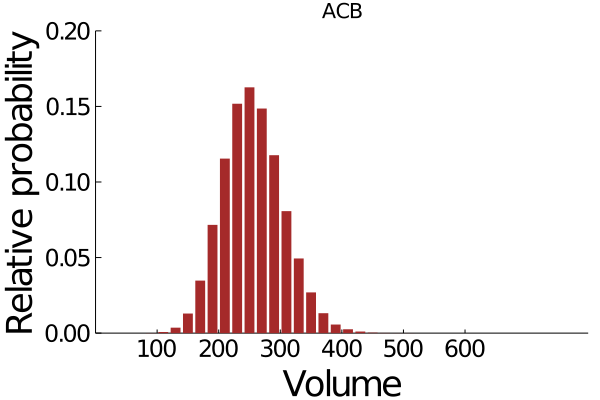

In [32]:
st = 20
bin_vol = collect(0:st:800)
wgh_vol = fill(1.0, length(vol_acb))

# Histograma ponderado
Wbins_vol_acb, Whis_vol_acb = JUMD.weightedHist(vol_acb, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_acb, Whis_vol_acb,
    xlims = (0, 800), ylims = (0, .2),
    xticks = 100:100:600,
    linecolor = false, fillcolor = Colors.colorant"Brown",
    grid = false, legend = false,
    guidefont = font(24, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"),
    title = "ACB", yaxis = "Relative probability", xaxis = "Volume")

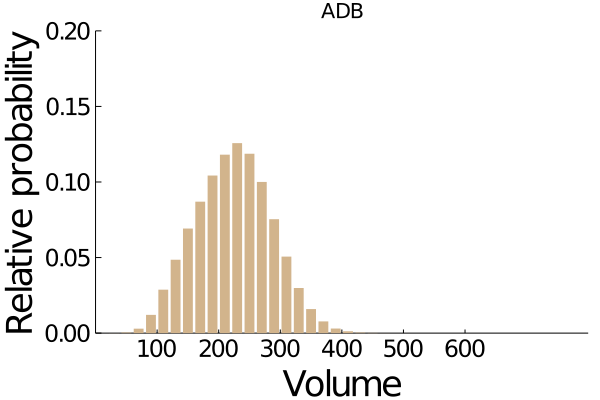

In [33]:
st = 20
bin_vol = collect(0:st:800)
wgh_vol = fill(1.0, length(vol_adb))

# Histograma ponderado
Wbins_vol_adb, Whis_vol_adb = JUMD.weightedHist(vol_adb, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_adb, Whis_vol_adb,
    xlims = (0, 800), ylims = (0, .2),
    xticks = 100:100:600,
    linecolor = false, fillcolor = Colors.colorant"Tan",
    grid = false, legend = false,
    guidefont = font(24, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"),
    title = "ADB", yaxis = "Relative probability", xaxis = "Volume")

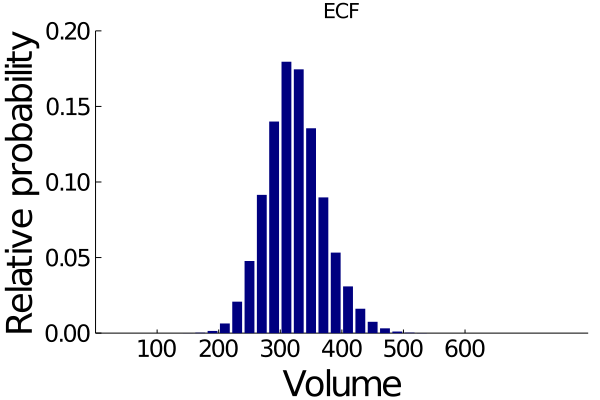

In [34]:
st = 20
bin_vol = collect(0:st:800)
wgh_vol = fill(1.0, length(vol_ecf))

# Histograma ponderado
Wbins_vol_ecf, Whis_vol_ecf = JUMD.weightedHist(vol_ecf, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_ecf, Whis_vol_ecf,
    xlims = (0, 800), ylims = (0, .2),
    xticks = 100:100:600,
    linecolor = false, fillcolor = Colors.colorant"Navy",
    grid = false, legend = false,
    guidefont = font(24, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"),
    title = "ECF", yaxis = "Relative probability", xaxis = "Volume")

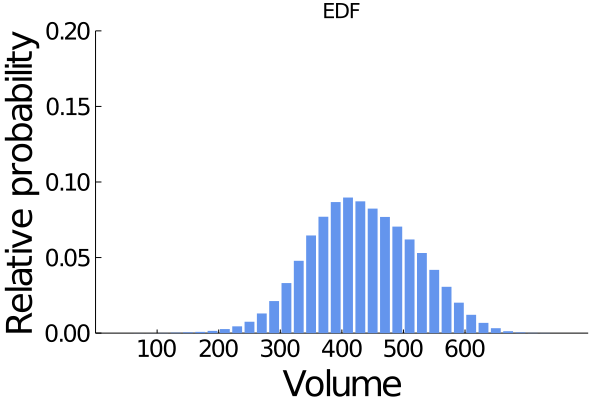

In [35]:
st = 20
bin_vol = collect(0:st:800)
wgh_vol = fill(1.0, length(vol_edf))

# Histograma ponderado
Wbins_vol_edf, Whis_vol_edf = JUMD.weightedHist(vol_edf, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_edf, Whis_vol_edf,
    xlims = (0, 800), ylims = (0, .2),
    xticks = 100:100:600,
    linecolor = false, fillcolor = Colors.colorant"CornflowerBlue",
    grid = false, legend = false,
    guidefont = font(24, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"),
    title = "EDF", yaxis = "Relative probability", xaxis = "Volume")

In [36]:
DataFrame(
    Volume = [ mean(vol_acb) ; mean(vol_adb) ; mean(vol_ecf) ; mean(vol_edf) ],
    STD = [ std(vol_acb) ; std(vol_adb) ; std(vol_ecf) ; std(vol_edf) ])

,Volume,STD
,Float64,Float64
1,255.639,49.0154
2,223.949,61.2395
3,323.573,46.3747
4,433.958,85.4731
